In [2]:
import yfinance as yf
import pandas as pd

tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
data = {}

for ticker in tickers:
    stock = yf.Ticker(ticker)
    hist = stock.history(period="1y")
    data[ticker] = hist

# Convert to DataFrame format
df_list = []
for ticker, hist in data.items():
    hist['Ticker'] = ticker
    df_list.append(hist)

df = pd.concat(df_list)
df.reset_index(inplace=True)


In [3]:
def create_features(df):
    df['Return'] = df['Close'].pct_change()
    df['Volatility'] = df['Return'].rolling(window=10).std()
    df['Momentum'] = df['Close'] / df['Close'].shift(10) - 1
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    df.dropna(inplace=True)
    return df

features = []
for ticker in tickers:
    df_ticker = df[df['Ticker'] == ticker].copy()
    df_features = create_features(df_ticker)
    features.append(df_features)

df_features = pd.concat(features)


In [4]:
# Calculate median volatility ONCE
vol_median = df_features['Volatility'].median()

# Update the function to use that precomputed value
def assign_quadrant(row):
    if row['Momentum'] > 0 and row['Volatility'] < vol_median:
        return 0  # Growth-Stable
    elif row['Momentum'] > 0 and row['Volatility'] >= vol_median:
        return 1  # Growth-Volatile
    elif row['Momentum'] <= 0 and row['Volatility'] < vol_median:
        return 2  # Value-Stable
    else:
        return 3  # Value-Volatile

# Apply corrected function
df_features['Quadrant'] = df_features.apply(assign_quadrant, axis=1)


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Prepare features and labels
X = df_features[['Return', 'Volatility', 'Momentum', 'MA10', 'MA50']]
y = df_features['Quadrant']

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode labels
y_encoded = to_categorical(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Build model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')  # 4 quadrants
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2904 - loss: 1.3930 - val_accuracy: 0.5494 - val_loss: 1.2631
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5301 - loss: 1.2302 - val_accuracy: 0.7222 - val_loss: 1.1224
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6169 - loss: 1.0918 - val_accuracy: 0.8025 - val_loss: 0.9805
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7187 - loss: 0.9610 - val_accuracy: 0.8333 - val_loss: 0.8266
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7617 - loss: 0.7741 - val_accuracy: 0.8642 - val_loss: 0.6820
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8396 - loss: 0.6542 - val_accuracy: 0.8889 - val_loss: 0.5628
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8556 - loss: 0.5391 - val_accuracy: 0.8765 - val_loss: 0.4752
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8739 - loss: 0.4368 - val_accuracy: 0.8951 - val_loss: 0.4019
Ep

In [6]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9651 - loss: 0.0886 
Test Accuracy: 0.97


In [7]:
pred = model.predict(X_test[:5])
print("Predicted Quadrants:", pred.argmax(axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted Quadrants: [2 3 0 1 3]


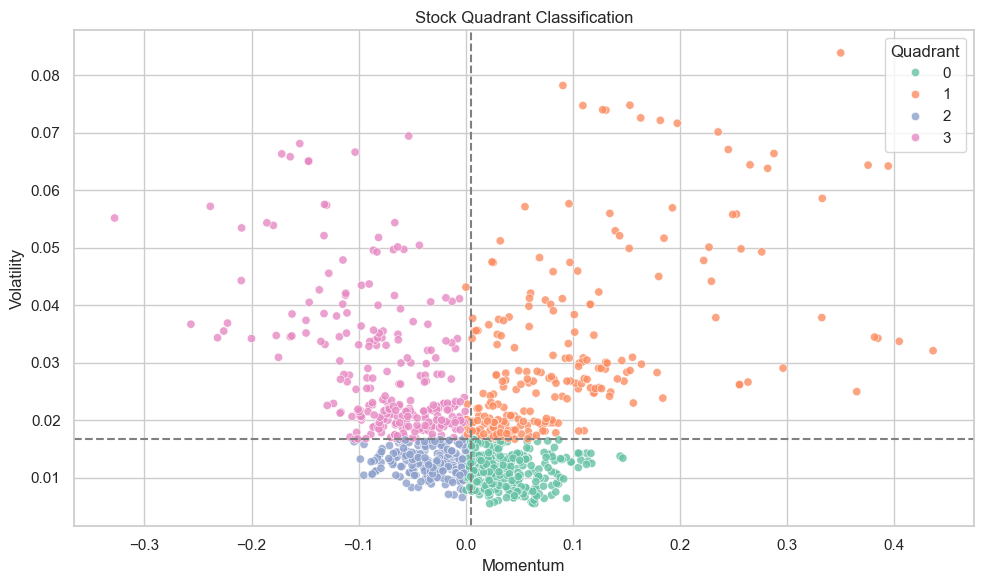

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_features,
    x="Momentum",
    y="Volatility",
    hue="Quadrant",
    palette="Set2",
    alpha=0.8
)

# Median lines for quadrant boundaries
momentum_median = df_features["Momentum"].median()
volatility_median = df_features["Volatility"].median()

plt.axvline(momentum_median, color='gray', linestyle='--')
plt.axhline(volatility_median, color='gray', linestyle='--')

# Labels and title
plt.title("Stock Quadrant Classification")
plt.xlabel("Momentum")
plt.ylabel("Volatility")
plt.legend(title="Quadrant", loc="upper right")
plt.tight_layout()
plt.show()


In [9]:
import plotly.express as px

# Optional: Sample to reduce overcrowding
# df_sample = df_features.sample(500)

fig = px.scatter(
    df_features,
    x="Momentum",
    y="Volatility",
    color="Quadrant",
    hover_data=["Ticker", "Momentum", "Volatility"],
    title="Interactive Stock Quadrant Classification (Momentum vs Volatility)",
    color_discrete_sequence=px.colors.qualitative.Set2,
    labels={"Quadrant": "Quadrant Category"},
    opacity=0.8
)

# Add median lines
momentum_median = df_features["Momentum"].median()
volatility_median = df_features["Volatility"].median()

fig.add_shape(type="line", x0=momentum_median, x1=momentum_median,
              y0=df_features["Volatility"].min(), y1=df_features["Volatility"].max(),
              line=dict(color="gray", dash="dash"))
fig.add_shape(type="line", x0=df_features["Momentum"].min(), x1=df_features["Momentum"].max(),
              y0=volatility_median, y1=volatility_median,
              line=dict(color="gray", dash="dash"))

fig.update_layout(
    xaxis_title="Momentum",
    yaxis_title="Volatility",
    legend_title="Quadrant",
    template="plotly_white"
)

fig.show()


In [10]:
import plotly.graph_objects as go

# ชื่อกลุ่ม
financial_levels = ['A', 'B', 'C', 'D', 'E']
trend_levels = ['a', 'b', 'c', 'd', 'e']

# สร้าง dictionary จำลองข้อมูลหุ้นในแต่ละ cell เช่น 'Aa': ['หุ้น1', 'หุ้น2']
quadrant_data = {
    f"{f}{t}": [f"หุ้น{f}{t}-1", f"หุ้น{f}{t}-2"] for f in financial_levels for t in trend_levels
}

# สร้างตารางข้อความ
table_text = []
for f in financial_levels:
    row = []
    for t in trend_levels:
        label = f"{f}{t}"
        stocks = quadrant_data[label]
        row.append(f"<b>{label}</b><br>" + "<br>".join(stocks))
    table_text.append(row)

# สีพื้นหลังตามระดับ
cell_colors = {
    'A': '#2ecc71',
    'B': '#58d68d',
    'C': '#f4d03f',
    'D': '#f39c12',
    'E': '#e74c3c'
}
colors = [[cell_colors[f]] * 5 for f in financial_levels]

# สร้าง figure
fig = go.Figure(data=go.Table(
    header=dict(
        values=["<b>Super Bullish</b>", "<b>Up Trend</b>", "<b>Sideway</b>", "<b>Down Trend</b>", "<b>Crash</b>"],
        align="center",
        font=dict(color="black", size=14),
        fill_color="#dcdcdc"
    ),
    cells=dict(
        values=table_text,
        align="center",
        font=dict(color="white", size=12),
        fill_color=colors,
        height=80
    )
))

fig.update_layout(title="Quadrant Stock Level")
fig.show()
